# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

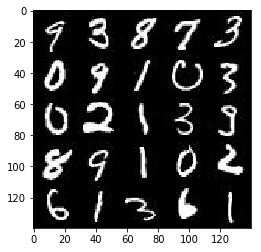

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

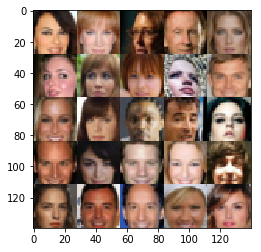

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
# Leaky ReLU, alpha sets the magnitude of the output for negative values
alpha = 0.1

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = images
        x1 = tf.layers.dropout(x1, rate=drop_rate)
        x1 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flatten = x3
        flatten = tf.layers.dropout(flatten, rate=drop_rate)
        flatten = tf.layers.flatten(flatten)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim

        out = tf.tanh(logits)  
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Label smoothing of d_loss_real
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
losses = []

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, model_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    n_images = 9
    steps = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale image, shoud be in range -1..1 not -0.5..0.5
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(
                    d_train_opt, 
                    feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_learning_rate: learning_rate})
                _ = sess.run(
                    g_train_opt, 
                    feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_learning_rate: learning_rate})
                _ = sess.run(
                    g_train_opt, 
                    feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, image_channels, data_image_mode)
                   
        saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8662... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 2.7389... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 2.4021... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 2.1162... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.8370... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 1.6622... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.7196... Generator Loss: 1.0049
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 1.0166


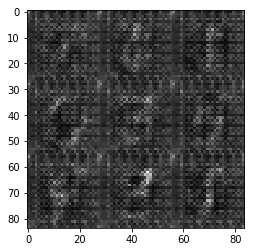

Epoch 1/2... Discriminator Loss: 1.5968... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.6259... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.5068... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.9150


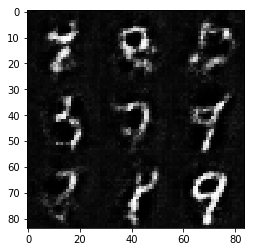

Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.9606
Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 0.8489


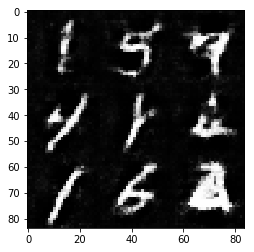

Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 0.4467
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.9767


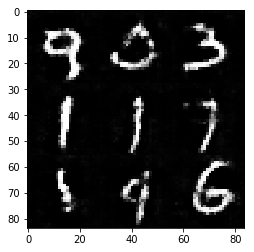

Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.6086... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 0.6816
Epoch 2/2... Discriminator Loss: 1.4262... Generator Loss: 0.7343


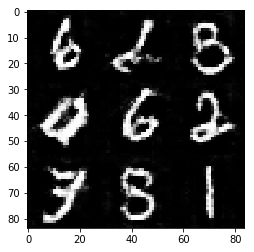

Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.4648... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.6713... Generator Loss: 1.2477
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.7134
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 1.6539... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.4949... Generator Loss: 0.5011


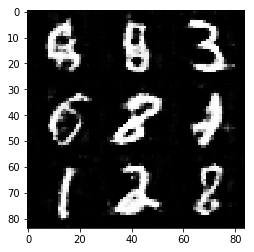

Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.5505... Generator Loss: 0.4580
Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.5366
Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.7218


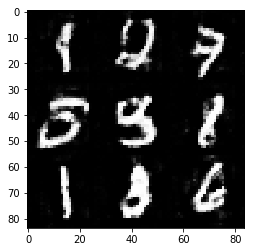

Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.4347... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.6930... Generator Loss: 1.0132


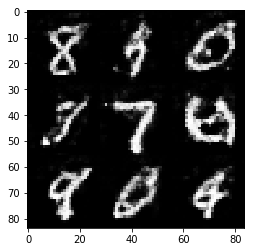

Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.6274... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.5803... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.6270


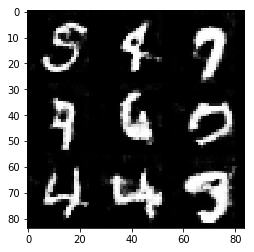

Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 1.8194... Generator Loss: 0.2842
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.5567


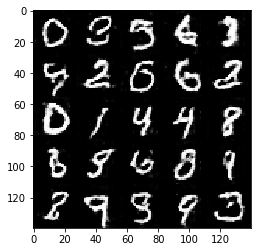

In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3

losses = []
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

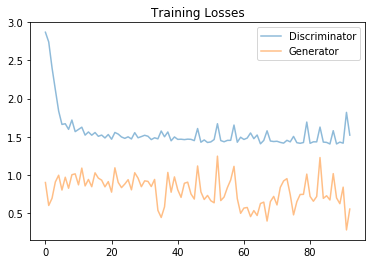

In [30]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.9749... Generator Loss: 0.0397
Epoch 1/1... Discriminator Loss: 2.7587... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 2.7226... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 2.3652... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 2.1801... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 2.0589... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 2.1652... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 2.3643... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.7818... Generator Loss: 0.6780


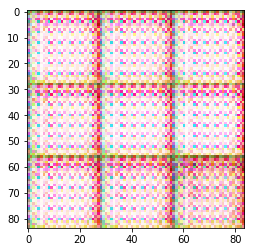

Epoch 1/1... Discriminator Loss: 1.8508... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.6672


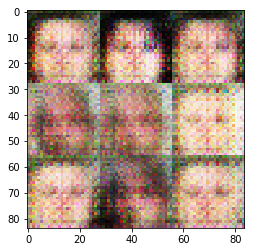

Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.6494... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.6958


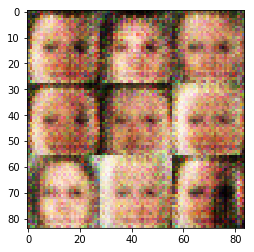

Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6830


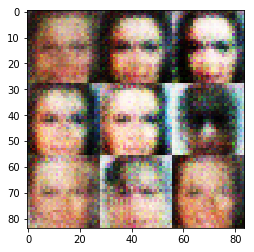

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7165


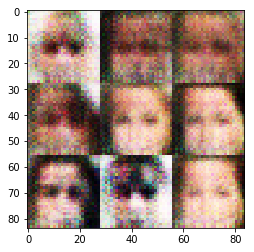

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7448


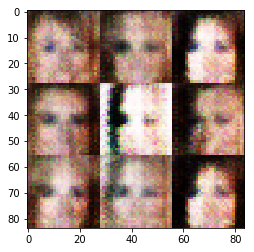

Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7186


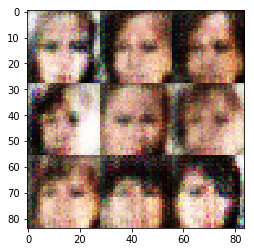

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6758


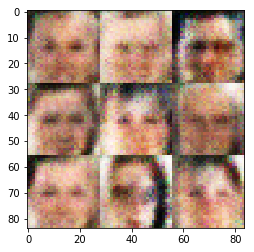

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7080


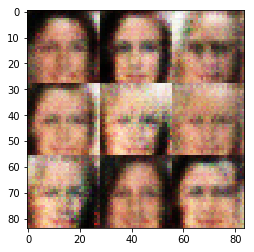

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7549


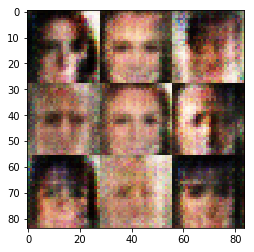

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7305


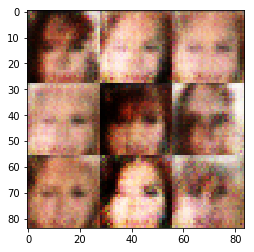

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6976


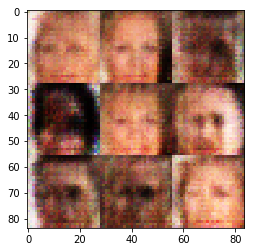

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7412


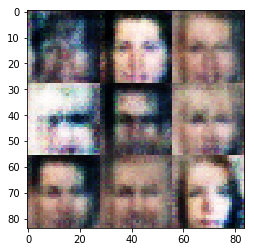

Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7671


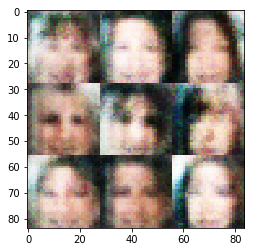

Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7791


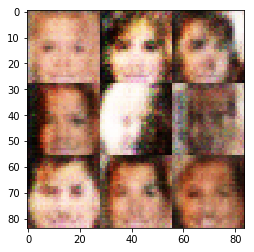

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7611


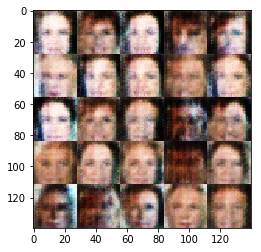

In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

losses = []
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

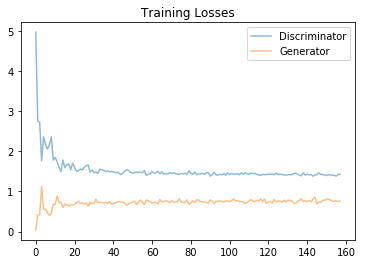

In [32]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.